upload mrpc_slang.json and mrpc_normal.txt

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving mrpc.json to mrpc.json
Saving mrpc_1.txt to mrpc_1.txt


Install and import Packages 

In [ ]:
!pip install -q -U "tensorflow-text==2.8.*"
!pip install -q tf-models-official==2.4.0

     |████████████████████████████████| 4.9 MB 9.7 MB/s 
     |████████████████████████████████| 1.1 MB 7.3 MB/s 
     |████████████████████████████████| 47.8 MB 1.2 MB/s 
     |████████████████████████████████| 99 kB 8.9 MB/s 
     |████████████████████████████████| 1.1 MB 58.3 MB/s 
     |████████████████████████████████| 596 kB 55.6 MB/s 
     |████████████████████████████████| 237 kB 73.6 MB/s 
     |████████████████████████████████| 352 kB 73.7 MB/s 
     |████████████████████████████████| 43 kB 1.8 MB/s 
     |████████████████████████████████| 1.2 MB 57.4 MB/s 


In [ ]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

# Load the required submodules
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks


Load BERT and install mrpc dataset

In [ ]:
gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/v3/uncased_L-12_H-768_A-12"
tf.io.gfile.listdir(gs_folder_bert)

['bert_config.json',
 'bert_model.ckpt.data-00000-of-00001',
 'bert_model.ckpt.index',
 'vocab.txt']

In [ ]:
hub_url_bert = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3"

In [ ]:
glue, info = tfds.load('glue/mrpc', with_info=True,
                       # It's small, load the whole dataset
                       batch_size=-1)

Shuffling and writing examples to /root/tensorflow_datasets/glue/mrpc/1.0.0.incompleteSVZB5D/glue-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/glue/mrpc/1.0.0.incompleteSVZB5D/glue-validation.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/glue/mrpc/1.0.0.incompleteSVZB5D/glue-test.tfrecord
Dataset glue downloaded and prepared to /root/tensorflow_datasets/glue/mrpc/1.0.0. Subsequent calls will reuse this data.
Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


Prepare tokenizer and encoder

In [ ]:
# Set up tokenizer to generate Tensorflow dataset
tokenizer = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(gs_folder_bert, "vocab.txt"),
     do_lower_case=True)

print("Vocab size:", len(tokenizer.vocab))

Vocab size: 30522


In [ ]:
tokens = tokenizer.tokenize("Hello Tensorflow!")
print(tokens)
ids = tokenizer.convert_tokens_to_ids(tokens)
print(ids)

['hello', 'tensor', '##flow', '!']
[7592, 23435, 12314, 999]


In [ ]:
def encode_sentence(s, tokenizer):
   tokens = list(tokenizer.tokenize(s))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(glue_dict, tokenizer):
  num_examples = len(glue_dict["sentence1"])

  sentence1 = tf.ragged.constant([
      encode_sentence(s, tokenizer)
      for s in np.array(glue_dict["sentence1"])])
  sentence2 = tf.ragged.constant([
      encode_sentence(s, tokenizer)
       for s in np.array(glue_dict["sentence2"])])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
  input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor()

  type_cls = tf.zeros_like(cls)
  type_s1 = tf.zeros_like(sentence1)
  type_s2 = tf.ones_like(sentence2)
  input_type_ids = tf.concat(
      [type_cls, type_s1, type_s2], axis=-1).to_tensor()

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs


Create dictionary of normal to slang 

In [ ]:
import json
import copy

In [ ]:
# Opening JSON file
f = open('mrpc_slang.json')
  
# returns JSON object as 
# a dictionary
data = json.load(f)
# Closing file
f.close()

In [ ]:
f = open('mrpc_normal.txt')
data2=f.read().splitlines()

# Closing file
f.close()

In [ ]:
normal_to_slang=dict(zip(data2,data))

Transform normal to slang

In [ ]:
sl_train_sen1=tf.constant(np.array([normal_to_slang[s.numpy().decode()] for s in glue["train"]["sentence1"]]))

sl_train_sen2=tf.constant(np.array([normal_to_slang[s.numpy().decode()] for s in glue["train"]["sentence2"]]))

sl_val_sen1=tf.constant(np.array([normal_to_slang[s.numpy().decode()] for s in glue["validation"]["sentence1"]]))

sl_val_sen2=tf.constant(np.array([normal_to_slang[s.numpy().decode()] for s in glue["validation"]["sentence2"]]))

sl_test_sen1=tf.constant(np.array([normal_to_slang[s.numpy().decode()] for s in glue["test"]["sentence1"]]))

sl_test_sen2=tf.constant(np.array([normal_to_slang[s.numpy().decode()] for s in glue["test"]["sentence2"]]))

In [ ]:
glue_normal=copy.deepcopy(glue)

In [ ]:
glue_slang=copy.deepcopy(glue)

In [ ]:
glue_mixed=copy.deepcopy(glue)

Glue mixed needs many combinations of slang nad normal pairs

In [ ]:
glue_mixed["train"]["sentence1"]=tf.concat([glue["train"]["sentence1"],sl_train_sen1,glue["train"]["sentence1"],sl_train_sen1],0)

glue_mixed["train"]["sentence2"]=tf.concat([glue["train"]["sentence2"],glue["train"]["sentence2"],sl_train_sen2,sl_train_sen2],0)

glue_mixed["train"]["label"]=tf.concat([glue["train"]["label"],glue["train"]["label"],glue["train"]["label"],glue["train"]["label"]],0)

glue_mixed["validation"]["sentence1"]=tf.concat([glue["validation"]["sentence1"],sl_val_sen1,glue["validation"]["sentence1"],sl_val_sen1],0)

glue_mixed["validation"]["sentence2"]=tf.concat([glue["validation"]["sentence2"],glue["validation"]["sentence2"],sl_val_sen2,sl_val_sen2],0)

glue_mixed["validation"]["label"]=tf.concat([glue["validation"]["label"],glue["validation"]["label"],glue["validation"]["label"],glue["validation"]["label"]],0)

glue_mixed["test"]["sentence1"]=tf.concat([glue["test"]["sentence1"],sl_test_sen1,glue["test"]["sentence1"],sl_test_sen1],0)

glue_mixed["test"]["sentence2"]=tf.concat([glue["test"]["sentence2"],glue["test"]["sentence2"],sl_test_sen2,sl_test_sen2],0)

glue_mixed["test"]["label"]=tf.concat([glue["test"]["label"],glue["test"]["label"],glue["test"]["label"],glue["test"]["label"]],0)

In [ ]:
glue_slang["train"]["sentence1"]=sl_train_sen1

glue_slang["train"]["sentence2"]=sl_train_sen2

glue_slang["train"]["label"]=glue["train"]["label"]

glue_slang["validation"]["sentence1"]=sl_val_sen1

glue_slang["validation"]["sentence2"]=sl_val_sen2

glue_slang["validation"]["label"]=glue["validation"]["label"]

glue_slang["test"]["sentence1"]=sl_test_sen1

glue_slang["test"]["sentence2"]=sl_test_sen2

glue_slang["test"]["label"]=glue["test"]["label"]

In [ ]:
glue_normal["validation"]["sentence2"][0]

<tf.Tensor: shape=(), dtype=string, numpy=b'The company said this impacted earnings by a penny a share .'>

In [ ]:
glue_slang["validation"]["sentence2"][0]

<tf.Tensor: shape=(), dtype=string, numpy=b'The company said dis impacted earnings by a penny a shr'>

In [ ]:
glue_mixed["validation"]["sentence2"][0]

<tf.Tensor: shape=(), dtype=string, numpy=b'The company said this impacted earnings by a penny a share .'>

In [ ]:
glue_mixed["validation"]["sentence2"][-1]

<tf.Tensor: shape=(), dtype=string, numpy=b'Businessweek online haz learned tht the settlement cud cum as early as monday , may 19'>

Encode sentences

In [ ]:
glue_train_normal = bert_encode(glue_normal['train'], tokenizer)
glue_train_normal_labels = glue_normal['train']['label']

glue_validation_normal = bert_encode(glue_normal['validation'], tokenizer)
glue_validation_normal_labels = glue_normal['validation']['label']

glue_test_normal = bert_encode(glue_normal['test'], tokenizer)
glue_test_normal_labels  = glue_normal['test']['label']

In [ ]:
glue_train_slang = bert_encode(glue_slang['train'], tokenizer)
glue_train_slang_labels = glue_slang['train']['label']

glue_validation_slang = bert_encode(glue_slang['validation'], tokenizer)
glue_validation_slang_labels = glue_slang['validation']['label']

glue_test_slang = bert_encode(glue_slang['test'], tokenizer)
glue_test_slang_labels  = glue_slang['test']['label']

In [ ]:
glue_train_mixed = bert_encode(glue_mixed['train'], tokenizer)
glue_train_mixed_labels = glue_mixed['train']['label']

glue_validation_mixed = bert_encode(glue_mixed['validation'], tokenizer)
glue_validation_mixed_labels = glue_mixed['validation']['label']

glue_test_mixed = bert_encode(glue_mixed['test'], tokenizer)
glue_test_mixed_labels  = glue_mixed["test"]["label"]

Prepare 3 classifiers

In [ ]:
import json

bert_config_file = os.path.join(gs_folder_bert, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())

bert_config = bert.configs.BertConfig.from_dict(config_dict)

config_dict

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 30522}

In [ ]:
bert_classifier_normal, bert_encoder_normal = bert.bert_models.classifier_model(
    bert_config, num_labels=2)

In [ ]:
bert_classifier_slang, bert_encoder_slang = bert.bert_models.classifier_model(
    bert_config, num_labels=2)

In [ ]:
bert_classifier_mixed, bert_encoder_mixed = bert.bert_models.classifier_model(
    bert_config, num_labels=2)

In [ ]:
#tf.keras.utils.plot_model(bert_classifier, show_shapes=True, dpi=48)

In [ ]:
#tf.keras.utils.plot_model(bert_encoder, show_shapes=True, dpi=48)

In [ ]:
# checkpoint = tf.train.Checkpoint(encoder=bert_encoder_normal)
# checkpoint.read(
#     os.path.join(gs_folder_bert, 'bert_model.ckpt')).assert_consumed()

In [ ]:
epochs = 10
batch_size = 32
eval_batch_size = 32

In [ ]:
# Set up epochs and steps
train_data_size = len(glue_train_normal_labels)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

# creates an optimizer with learning rate schedule
optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

bert_classifier_normal.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)

bert_classifier_normal.fit(
      glue_train_normal, glue_train_normal_labels,
      validation_data=(glue_validation_normal, glue_validation_normal_labels),
      batch_size=32,
      epochs=epochs)

Epoch 1/10
115/115 [==============================] - 65s 415ms/step - loss: 0.6430 - accuracy: 0.6595 - val_loss: 0.6291 - val_accuracy: 0.6838
Epoch 2/10
115/115 [==============================] - 46s 399ms/step - loss: 0.6296 - accuracy: 0.6712 - val_loss: 0.5992 - val_accuracy: 0.6642
Epoch 3/10
115/115 [==============================] - 46s 399ms/step - loss: 0.5933 - accuracy: 0.6908 - val_loss: 0.5903 - val_accuracy: 0.6838
Epoch 4/10
115/115 [==============================] - 46s 400ms/step - loss: 0.5470 - accuracy: 0.7135 - val_loss: 0.6099 - val_accuracy: 0.6863
Epoch 5/10
115/115 [==============================] - 46s 399ms/step - loss: 0.4651 - accuracy: 0.7816 - val_loss: 0.6672 - val_accuracy: 0.6838
Epoch 6/10
115/115 [==============================] - 46s 399ms/step - loss: 0.3906 - accuracy: 0.8274 - val_loss: 0.7230 - val_accuracy: 0.6520
Epoch 7/10
115/115 [==============================] - 46s 399ms/step - loss: 0.3430 - accuracy: 0.8539 - val_loss: 0.7481 - val_ac

In [ ]:
# Set up epochs and steps

train_data_size = len(glue_train_slang_labels)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

# creates an optimizer with learning rate schedule
optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

bert_classifier_slang.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)

bert_classifier_slang.fit(
      glue_train_slang, glue_train_slang_labels,
      validation_data=(glue_validation_slang, glue_validation_slang_labels),
      batch_size=32,
      epochs=epochs)

Epoch 1/10
115/115 [==============================] - 62s 427ms/step - loss: 0.6492 - accuracy: 0.6445 - val_loss: 0.6371 - val_accuracy: 0.6838
Epoch 2/10
115/115 [==============================] - 48s 417ms/step - loss: 0.6276 - accuracy: 0.6731 - val_loss: 0.6569 - val_accuracy: 0.6936
Epoch 3/10
115/115 [==============================] - 48s 417ms/step - loss: 0.5832 - accuracy: 0.6938 - val_loss: 0.6000 - val_accuracy: 0.6961
Epoch 4/10
115/115 [==============================] - 48s 417ms/step - loss: 0.5318 - accuracy: 0.7312 - val_loss: 0.6036 - val_accuracy: 0.6936
Epoch 5/10
115/115 [==============================] - 48s 417ms/step - loss: 0.4623 - accuracy: 0.7868 - val_loss: 0.8387 - val_accuracy: 0.7059
Epoch 6/10
115/115 [==============================] - 48s 417ms/step - loss: 0.3891 - accuracy: 0.8244 - val_loss: 0.7505 - val_accuracy: 0.6397
Epoch 7/10
115/115 [==============================] - 48s 417ms/step - loss: 0.3501 - accuracy: 0.8484 - val_loss: 0.8601 - val_ac

In [ ]:
# Set up epochs and steps

train_data_size = len(glue_train_mixed_labels)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

# creates an optimizer with learning rate schedule
optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

bert_classifier_mixed.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)

bert_classifier_mixed.fit(
      glue_train_mixed, glue_train_mixed_labels,
      validation_data=(glue_validation_mixed, glue_validation_mixed_labels),
      batch_size=32,
      epochs=epochs)

Epoch 1/10
459/459 [==============================] - 206s 420ms/step - loss: 0.6250 - accuracy: 0.6763 - val_loss: 0.6179 - val_accuracy: 0.6679
Epoch 2/10
459/459 [==============================] - 191s 417ms/step - loss: 0.4313 - accuracy: 0.8040 - val_loss: 1.2171 - val_accuracy: 0.6844
Epoch 3/10
459/459 [==============================] - 195s 426ms/step - loss: 0.2313 - accuracy: 0.9115 - val_loss: 1.1020 - val_accuracy: 0.6691
Epoch 4/10
459/459 [==============================] - 192s 417ms/step - loss: 0.1590 - accuracy: 0.9462 - val_loss: 1.3673 - val_accuracy: 0.6526
Epoch 5/10
459/459 [==============================] - 192s 418ms/step - loss: 0.1307 - accuracy: 0.9571 - val_loss: 1.5816 - val_accuracy: 0.6268
Epoch 6/10
459/459 [==============================] - 192s 417ms/step - loss: 0.0950 - accuracy: 0.9737 - val_loss: 1.7858 - val_accuracy: 0.6569
Epoch 7/10
459/459 [==============================] - 191s 417ms/step - loss: 0.0795 - accuracy: 0.9783 - val_loss: 1.9592 -

Check models on all cases: normal, slang, mixed

In [ ]:
# model_dataset

In [ ]:
# result_normal_normal=[bert_classifier_normal([{'input_mask':glue_validation_normal["input_mask"][i:i+25] ,'input_type_ids':glue_validation_normal["input_type_ids"][i:i+25],'input_word_ids':glue_validation_normal["input_word_ids"][i:i+25]}], training=False) for i in range(0,len(glue_validation_normal_labels),25)]
# result_normal_normal= tf.concat(result_normal_normal,0)
result_normal_normal = bert_classifier_normal(glue_validation_normal)
result_normal_normal = tf.argmax(result_normal_normal, axis = -1).numpy()
result_normal_normal = np.mean(result_normal_normal==glue_validation_normal_labels.numpy())
result_normal_normal

0.6838235294117647

In [ ]:
# result_slang_normal=[bert_classifier_slang([{'input_mask':glue_validation_normal["input_mask"][i:i+25] ,'input_type_ids':glue_validation_normal["input_type_ids"][i:i+25],'input_word_ids':glue_validation_normal["input_word_ids"][i:i+25]}], training=False) for i in range(0,len(glue_validation_normal_labels),25)]
# result_slang_normal=tf.concat(result_slang_normal,0)
result_slang_normal = bert_classifier_slang(glue_validation_normal)
result_slang_normal = tf.argmax(result_slang_normal, axis = -1).numpy()
result_slang_normal = np.mean(result_slang_normal==glue_validation_normal_labels.numpy())
result_slang_normal

0.6911764705882353

In [ ]:
# result_mixed_normal=[bert_classifier_mixed([{'input_mask':glue_validation_normal["input_mask"][i:i+25] ,'input_type_ids':glue_validation_normal["input_type_ids"][i:i+25],'input_word_ids':glue_validation_normal["input_word_ids"][i:i+25]}], training=False) for i in range(0,len(glue_validation_normal_labels),25)]
# result_mixed_normal=tf.concat(result_mixed_normal,0)
result_mixed_normal = bert_classifier_mixed(glue_validation_normal)
result_mixed_normal = tf.argmax(result_mixed_normal, axis = -1).numpy()
result_mixed_normal = np.mean(result_mixed_normal==glue_validation_normal_labels.numpy())
result_mixed_normal

0.6519607843137255

In [ ]:
# result_normal_slang=[bert_classifier_normal([{'input_mask':glue_validation_slang["input_mask"][i:i+25] ,'input_type_ids':glue_validation_slang["input_type_ids"][i:i+25],'input_word_ids':glue_validation_slang["input_word_ids"][i:i+25]}], training=False) for i in range(0,len(glue_validation_slang_labels),25)]
# result_normal_slang=tf.concat(result_normal_slang,0)
result_normal_slang = bert_classifier_normal(glue_validation_slang)
result_normal_slang = tf.argmax(result_normal_slang, axis = -1).numpy()
result_normal_slang = np.mean(result_normal_slang==glue_validation_slang_labels.numpy())
result_normal_slang

0.6568627450980392

In [ ]:
# result_slang_slang=[bert_classifier_slang([{'input_mask':glue_validation_slang["input_mask"][i:i+25] ,'input_type_ids':glue_validation_slang["input_type_ids"][i:i+25],'input_word_ids':glue_validation_slang["input_word_ids"][i:i+25]}], training=False) for i in range(0,len(glue_validation_slang_labels),25)]
# result_slang_slang=tf.concat(result_slang_slang,0)
result_slang_slang = bert_classifier_slang(glue_validation_slang)
result_slang_slang = tf.argmax(result_slang_slang, axis = -1).numpy()
result_slang_slang = np.mean(result_slang_slang==glue_validation_slang_labels.numpy())
result_slang_slang

0.6740196078431373

In [ ]:
# result_mixed_slang=[bert_classifier_mixed([{'input_mask':glue_validation_slang["input_mask"][i:i+25] ,'input_type_ids':glue_validation_slang["input_type_ids"][i:i+25],'input_word_ids':glue_validation_slang["input_word_ids"][i:i+25]}], training=False) for i in range(0,len(glue_validation_slang_labels),25)]
# result_mixed_slang=tf.concat(result_mixed_slang,0)
result_mixed_slang = bert_classifier_mixed(glue_validation_slang)
result_mixed_slang = tf.argmax(result_mixed_slang, axis = -1).numpy()
result_mixed_slang = np.mean(result_mixed_slang==glue_validation_slang_labels.numpy())
result_mixed_slang

0.6323529411764706

In [ ]:
# result_normal_mixed=[bert_classifier_normal([{'input_mask':glue_validation_mixed["input_mask"][i:i+25] ,'input_type_ids':glue_validation_mixed["input_type_ids"][i:i+25],'input_word_ids':glue_validation_mixed["input_word_ids"][i:i+25]}], training=False) for i in range(0,len(glue_validation_mixed_labels),25)]
# result_normal_mixed=tf.concat(result_normal_mixed,0)
result_normal_mixed = bert_classifier_normal(glue_validation_mixed)
result_normal_mixed = tf.argmax(result_normal_mixed, axis = -1).numpy()
result_normal_mixed = np.mean(result_normal_mixed==glue_validation_mixed_labels.numpy())
result_normal_mixed

0.6703431372549019

In [ ]:
# result_slang_mixed=[bert_classifier_slang([{'input_mask':glue_validation_mixed["input_mask"][i:i+25] ,'input_type_ids':glue_validation_mixed["input_type_ids"][i:i+25],'input_word_ids':glue_validation_mixed["input_word_ids"][i:i+25]}], training=False) for i in range(0,len(glue_validation_mixed_labels),25)]
# result_slang_mixed=tf.concat(result_slang_mixed,0)
result_slang_mixed = bert_classifier_slang(glue_validation_mixed)
result_slang_mixed = tf.argmax(result_slang_mixed, axis = -1).numpy()
result_slang_mixed = np.mean(result_slang_mixed==glue_validation_mixed_labels.numpy())
result_slang_mixed

0.6783088235294118

In [ ]:
# result_mixed_mixed=[bert_classifier_mixed([{'input_mask':glue_validation_mixed["input_mask"][i:i+25] ,'input_type_ids':glue_validation_mixed["input_type_ids"][i:i+25],'input_word_ids':glue_validation_mixed["input_word_ids"][i:i+25]}], training=False) for i in range(0,len(glue_validation_mixed_labels),25)]
# result_mixed_mixed=tf.concat(result_mixed_mixed,0)
result_mixed_mixed = bert_classifier_mixed(glue_validation_mixed)
result_mixed_mixed = tf.argmax(result_mixed_mixed, axis = -1).numpy()
result_mixed_mixed = np.mean(result_mixed_mixed==glue_validation_mixed_labels.numpy())
result_mixed_mixed

0.6421568627450981

Plot the results

In [9]:
import pandas as pd


In [ ]:
results=pd.DataFrame({"Accuracy":[result_normal_normal,result_slang_normal,result_mixed_normal,result_normal_mixed,result_slang_mixed,result_mixed_mixed,result_normal_slang,result_slang_slang,result_mixed_slang],
              "Model":["Normal","Slang","Mixed","Normal","Slang","Mixed","Normal","Slang","Mixed"],
              "Test":["Normal","Normal","Normal","Mixed","Mixed","Mixed","Slang","Slang","Slang"]
              })

In [10]:
import seaborn as sns

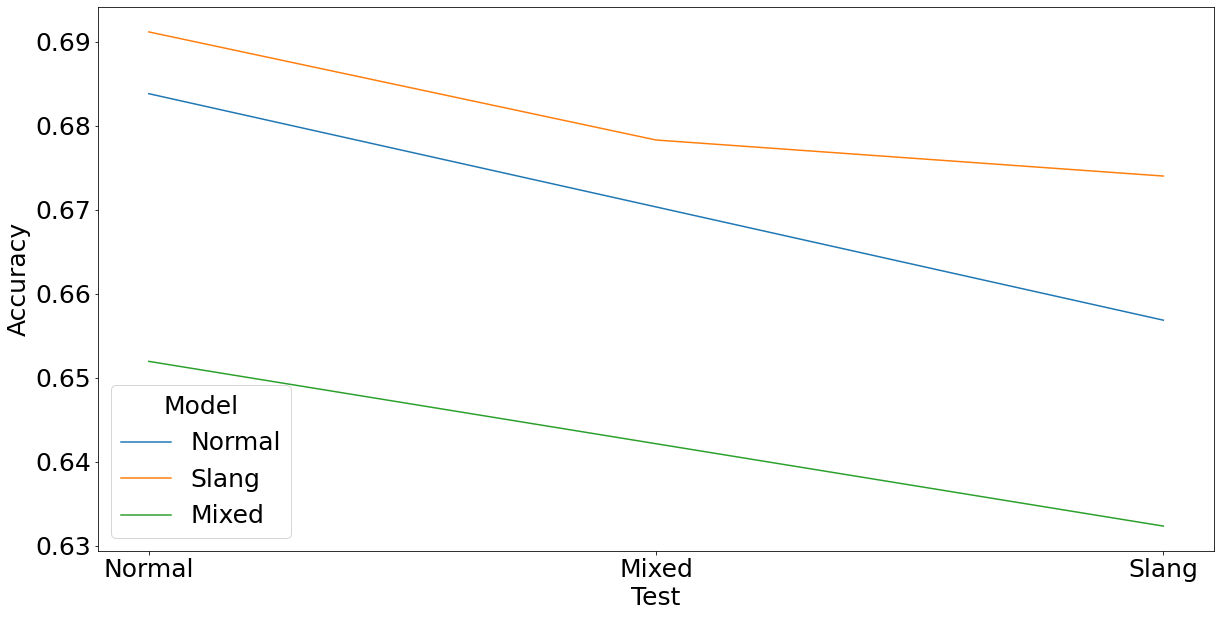

In [ ]:
plt.rcParams.update({'font.size': 25})
plt.figure(figsize=(20,10))
sns.lineplot(data=results,x="Test",y="Accuracy",hue="Model")

In [ ]:
export_dir='./saved_model'
tf.saved_model.save(bert_classifier_normal, export_dir=export_dir)

INFO:tensorflow:Assets written to: ./saved_model/assets


INFO:tensorflow:Assets written to: ./saved_model/assets


In [ ]:
export_dir='./saved_model'
tf.saved_model.save(bert_classifier_slang, export_dir=export_dir)

INFO:tensorflow:Assets written to: ./saved_model/assets


INFO:tensorflow:Assets written to: ./saved_model/assets


In [ ]:
export_dir='./saved_model'
tf.saved_model.save(bert_classifier_mixed, export_dir=export_dir)

INFO:tensorflow:Assets written to: ./saved_model/assets


INFO:tensorflow:Assets written to: ./saved_model/assets


In [5]:
df1={"loss_train":[0.6430,0.6296,0.5933,0.5470,0.4651,0.3906,0.3430,0.2809,0.2539,0.2084],"loss_validation":[0.6291,0.5992,0.5903,0.6099,0.6672,0.7230,0.7481,0.8071,0.8405,0.8667],"accuracy_train":[0.6595,0.6712,0.6908,0.7135,0.7816,0.8274,0.8539,0.8855,0.9002,0.9174],"accuracy_test":[0.6838,0.6642,0.6838,0.6863,0.6838,0.6520,0.6863,0.6838,0.6912,0.6838],"Model":["Normal","Normal","Normal","Normal","Normal","Normal","Normal","Normal","Normal","Normal"]}

In [6]:
df2={"loss_train":[0.6492,0.6276,0.5832,0.5318,0.4623,0.3891,0.3501,0.3133,0.2646,0.2321],"loss_validation":[0.6371,0.6569,0.6000,0.6036,0.8387,0.7505,0.8601,0.9050,0.9298,0.9453],"accuracy_train":[0.6445,0.6731,0.6938,0.7312,0.7868,0.8244,0.8484,0.8754,0.8909,0.9081],"accuracy_test":[0.6838,0.6936,0.6961,0.6936,0.7059,0.6397,0.6103,0.6642,0.6838,0.6740],"Model":["Slang","Slang","Slang","Slang","Slang","Slang","Slang","Slang","Slang","Slang"]}

In [7]:
df3={"loss_train":[0.6250,0.4313,0.2313,0.1590,0.1307,0.0950,0.0795,0.0572,0.0478,0.0312],"loss_validation":[0.6179,1.2171,1.1020,1.3673,1.5816,1.7858,1.9592,2.3565,2.6132,2.6003],"accuracy_train":[0.6763,0.8040,0.9115,0.9462,0.9571,0.9737,0.9783,0.9866,0.9887,0.9925],"accuracy_test":[0.6679,0.6844,0.6691,0.6526,0.6268,0.6569,0.6501,0.6244,0.6195,0.6422],"Model":["Mixed","Mixed","Mixed","Mixed","Mixed","Mixed","Mixed","Mixed","Mixed","Mixed"]}

In [27]:
df1=pd.DataFrame(df1)
df2=pd.DataFrame(df2)
df3=pd.DataFrame(df3)

In [28]:
df1["Epoch"]=range(10)
df2["Epoch"]=range(10)
df3["Epoch"]=range(10)

In [29]:
df=pd.concat([df1,df2,df3])

In [30]:
df4=pd.melt(df,id_vars=["Model","Epoch"])

In [31]:
df4

,Model,Epoch,variable,value
0,Normal,0,loss_train,0.6430
1,Normal,1,loss_train,0.6296
2,Normal,2,loss_train,0.5933
3,Normal,3,loss_train,0.5470
4,Normal,4,loss_train,0.4651
...,...,...,...,...
115,Mixed,5,accuracy_test,0.6569
116,Mixed,6,accuracy_test,0.6501
117,Mixed,7,accuracy_test,0.6244
118,Mixed,8,accuracy_test,0.6195


In [33]:
import matplotlib.pyplot as plt

<Figure size 1440x1152 with 0 Axes>

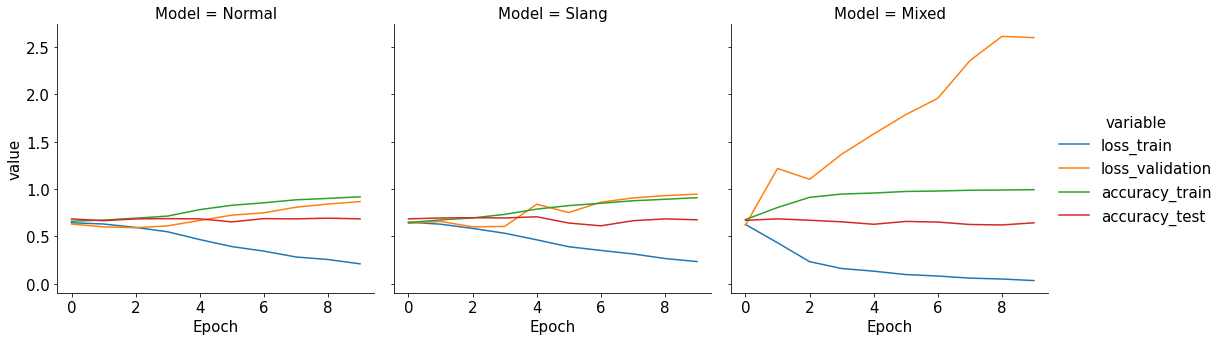

In [38]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(20,16))
sns.relplot(data=df4,x="Epoch",y="value",hue="variable",col="Model",kind="line")